# Exploratory data analysis

Perform EDA

In [1]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Activation, Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU

import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Users/diana.xie/.pyenv/versions/3.6.8/envs/penn_challenge/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 1. Import & Preprocessing

## 1A. Time

In [2]:
data = pd.read_csv(
    'bitcoin.csv', 
    index_col=0
)

# convert date to datetime
time_features = ['time_period_start', 'time_period_end', 'time_open', 'time_close']
for feat in time_features:
    data[feat] = pd.to_datetime(data[feat])

# choose time period end as the defining time point, due to short latencies
data['hour'] = [x.hour for x in data['time_period_end']]  # make hour of day a feature, in case useful
data = data.sort_values('time_period_end')
data.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour
0,2020-01-01 00:00:00+00:00,2020-01-01 00:00:01+00:00,2020-01-01 00:00:00.222256+00:00,2020-01-01 00:00:00.822153+00:00,7165.72,7165.72,7165.71,7165.71,0.021841,2,0
1,2020-01-01 00:00:01+00:00,2020-01-01 00:00:02+00:00,2020-01-01 00:00:01.949000+00:00,2020-01-01 00:00:01.953000+00:00,7168.30,7168.30,7168.30,7168.30,1.000000,2,0
2,2020-01-01 00:00:02+00:00,2020-01-01 00:00:03+00:00,2020-01-01 00:00:02.555000+00:00,2020-01-01 00:00:02.555000+00:00,7170.50,7170.50,7170.50,7170.50,0.002000,1,0
3,2020-01-01 00:00:04+00:00,2020-01-01 00:00:05+00:00,2020-01-01 00:00:04.171000+00:00,2020-01-01 00:00:04.560000+00:00,7169.20,7169.20,7169.20,7169.20,0.004000,2,0
4,2020-01-01 00:00:05+00:00,2020-01-01 00:00:06+00:00,2020-01-01 00:00:05.379000+00:00,2020-01-01 00:00:05.379000+00:00,7169.20,7169.20,7169.20,7169.20,0.002000,1,0


In [3]:
# Examine duration of time periods
length_trade_day = (data['time_open'] - data['time_close']).unique()
length_trade_day = length_trade_day/np.timedelta64(1, 's')
print('Diff, time_open & time_close: ', length_trade_day.max(), ' sec')
print('Unique vals, diff, time_open & time_close: ', len(set(length_trade_day)), '\n')

length_trade_day = (data['time_period_start'] - data['time_period_end']).unique()
length_trade_day = length_trade_day/np.timedelta64(1, 's')
print('Diff, time_period_start & time_period_close: ', length_trade_day.max(), ' sec')
print('Unique vals, diff, time_period_start & time_period_close: ', len(set(length_trade_day)), '\n')

print("Max date: ", data['time_period_end'].max())
print("Min date: ", data['time_period_end'].min())

Diff, time_open & time_close:  0.0  sec
Unique vals, diff, time_open & time_close:  2298 

Diff, time_period_start & time_period_close:  -1.0  sec
Unique vals, diff, time_period_start & time_period_close:  1 

Max date:  2020-01-01 08:08:01+00:00
Min date:  2020-01-01 00:00:01+00:00


In [4]:
data.drop(['time_period_end','time_period_start',  'time_open', 'time_close'], 
          axis=1, 
          inplace=True
         )  # drop unused time features
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour
0,7165.72,7165.72,7165.71,7165.71,0.021841,2,0
1,7168.30,7168.30,7168.30,7168.30,1.000000,2,0
2,7170.50,7170.50,7170.50,7170.50,0.002000,1,0
3,7169.20,7169.20,7169.20,7169.20,0.004000,2,0
4,7169.20,7169.20,7169.20,7169.20,0.002000,1,0


- Can drop dates as features, AFTER sorting, since all from same day.

In [ ]:
# assert len(set(months))==1, "The months aren't standardized per row.".format(x)
# assert len(set(days))==1, "The days aren't standardized per row.".format(x)
# assert len(set(years))==1, "The years aren't standardized per row.".format(x)

## 1B. Value

In [112]:
# Examine price difference during day
(data['price_high']-data['price_low']).describe()

count    10000.000000
mean         0.309933
std          1.175067
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.950000
dtype: float64

May need to cluster the days where price difference dramatic.

In [113]:
((data['price_high']-data['price_low']) > 0).sum()

1390

In [114]:
((data['price_low']-data['price_high']) > 0).sum()

0

In [115]:
((data['price_low']-data['price_high']) == 0).sum()

8610

In [116]:
((data['price_open']-data['price_close']) != 0).sum()

4564

Many days <b>did not</b> see a <b>price change.

## 1C. Volume

In [117]:
data.describe()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,7188.689161,7188.836551,7188.526618,7190.663989,0.316941,1.748300,3.22710
std,16.485485,16.410394,16.571811,18.341736,1.810771,2.215815,2.32733
min,7144.620000,7144.620000,7136.050000,7144.620000,0.000008,1.000000,0.00000
25%,7184.950000,7185.000000,7184.757500,7184.887500,0.006210,1.000000,1.00000
50%,7196.970000,7197.310000,7196.640000,7196.960000,0.015223,1.000000,3.00000
75%,7201.000000,7201.000000,7201.000000,7203.250000,0.068103,2.000000,5.00000
max,7201.000000,7201.000000,7201.000000,7223.500000,65.014193,88.000000,8.00000


It seems num trades (i.e. `trades_count`) range large. 
- Whereas price differences low, prob due to very high Bitcoin val per 1.0 Bitcoin.

May also need to cluster for large-volume days.

# 2. Quick examine of all features

CPU times: user 7.82 s, sys: 341 ms, total: 8.16 s
Wall time: 8.12 s


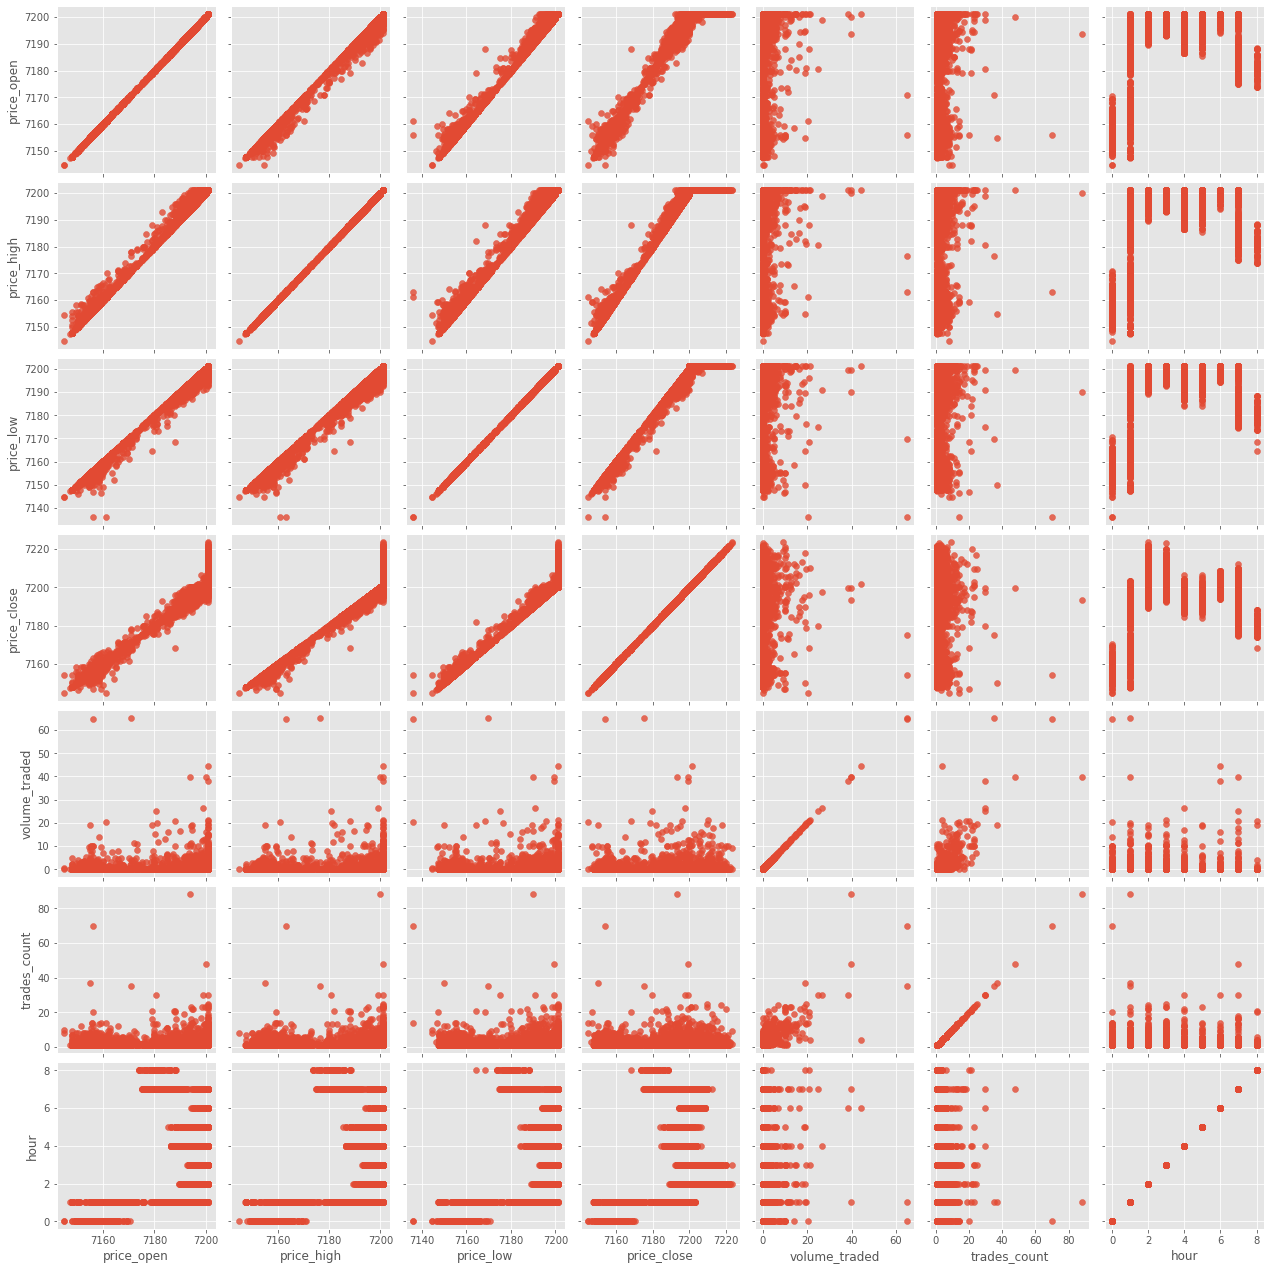

In [121]:
%%time

# features = ['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count', 'hour']

g = sns.PairGrid(data, vars=list(data.columns), palette='RdBu_r');
g.map(plt.scatter, alpha=0.8);
g.add_legend();

<AxesSubplot:xlabel='price_close'>

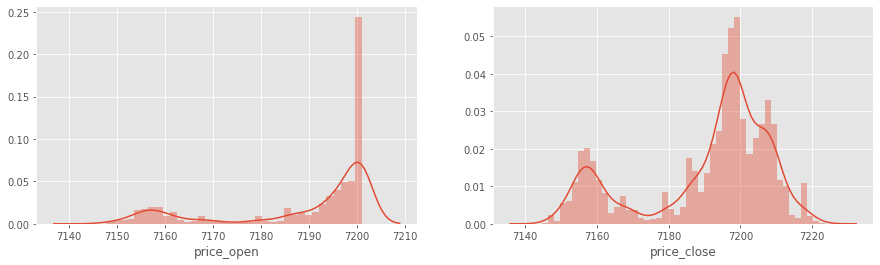

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(data['price_open'], ax=ax1)
sns.distplot(data['price_close'], ax=ax2)

<AxesSubplot:xlabel='price_low'>

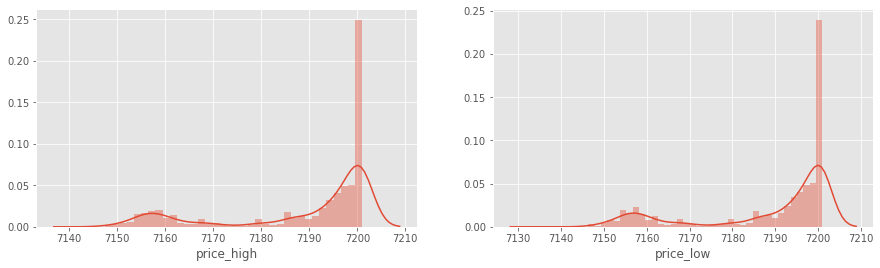

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(data['price_high'], ax=ax1)
sns.distplot(data['price_low'], ax=ax2)

# 3. Lookback Window

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

Question: Is this a good feature set? Can you find a better one?

<b>Response</b>: A good start, but given the poor predictions/error (see later responses), additional models and features/feature engineering should be explored to improve this error.

In [10]:
%%time

features_nontime = \
['price_open',
 'price_high',
 'price_low',
 'price_close',
 'volume_traded',
 'trades_count']

def lookback(dataset, features, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    for i in range(1, timesteps):
        step_back = dataset[features].shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset[features].columns if column != 'index']
        dataset = dataset.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return dataset.dropna()
        
features = lookback(data, features_nontime, 60)

CPU times: user 2.98 s, sys: 1.91 s, total: 4.89 s
Wall time: 5.09 s


In [11]:
features

,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour,price_open_-1,price_high_-1,price_low_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,0,7163.30,7163.30,7163.30,...,7168.30,7168.30,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,0,7154.97,7154.97,7154.97,...,7170.50,7170.50,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,0,7161.20,7163.40,7161.20,...,7169.20,7169.20,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,0,7154.98,7154.98,7154.97,...,7169.20,7169.20,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,0,7154.98,7154.98,7154.98,...,7165.72,7169.20,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7179.50,7179.50,7179.50,7179.50,0.013325,1,8,7179.04,7179.04,7178.23,...,7178.64,7178.64,0.006793,1.0,7179.88,7179.88,7179.88,7179.88,0.009628,1.0
9996,7181.67,7181.67,7181.67,7181.67,0.013364,1,8,7179.50,7179.50,7179.50,...,7178.64,7178.64,0.001249,1.0,7178.64,7178.64,7178.64,7178.64,0.006793,1.0
9997,7179.50,7179.50,7179.50,7179.50,0.001526,1,8,7181.67,7181.67,7181.67,...,7178.64,7178.64,0.068287,1.0,7178.64,7178.64,7178.64,7178.64,0.001249,1.0
9998,7182.12,7182.12,7182.12,7182.12,0.013437,1,8,7179.50,7179.50,7179.50,...,7173.77,7173.77,0.008064,1.0,7178.64,7178.64,7178.64,7178.64,0.068287,1.0


In [124]:
# features.to_pickle('features.pkl')

Text(0.5, 1.0, 'Price High - Aggregation')

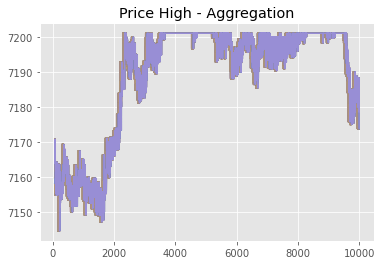

In [15]:
plot_features = [x for x in features.columns if 'price_high' in x]
plot_features.remove('price_high')

plt.plot(features[plot_features]);
plt.title('Price High - Aggregation');

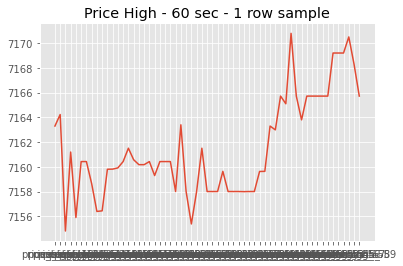

In [16]:
plt.plot(features[plot_features].iloc[0]);
plt.title('Price High - 60 sec - 1 row sample');

It looks like sequential data will be important. However, the prices do follow a rough pattern at the aggregated level.

# 4. Evaluate - neural net

In [12]:
### split data into features and target
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

In [28]:
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1]))
model.add(Dense(16))
model.add(Dense(1, activation='relu'))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target,
    validation_split=.3,
    epochs=20,
    verbose=1
)

Epoch 1/20
218/218 [==============================] - 0s 2ms/step - loss: 51633492.0000 - mean_squared_error: 51633492.0000 - mean_absolute_error: 7185.6216 - val_loss: 51795036.0000 - val_mean_squared_error: 51795036.0000 - val_mean_absolute_error: 7196.8774
Epoch 2/20
218/218 [==============================] - 0s 1ms/step - loss: 51633472.0000 - mean_squared_error: 51633472.0000 - mean_absolute_error: 7185.6206 - val_loss: 51795036.0000 - val_mean_squared_error: 51795036.0000 - val_mean_absolute_error: 7196.8774
Epoch 3/20
218/218 [==============================] - 0s 2ms/step - loss: 51633520.0000 - mean_squared_error: 51633520.0000 - mean_absolute_error: 7185.6216 - val_loss: 51795036.0000 - val_mean_squared_error: 51795036.0000 - val_mean_absolute_error: 7196.8774
Epoch 4/20
218/218 [==============================] - 0s 1ms/step - loss: 51633480.0000 - mean_squared_error: 51633480.0000 - mean_absolute_error: 7185.6216 - val_loss: 51795036.0000 - val_mean_squared_error: 51795036.00

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                11552     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


Below we calculate predictions and root mean square error. Can we easily improve this RMSE?

<b>Response</b>: Yes, we should likely be able to improve this RMSE due to "dying ReLU" (gradient ends up 0, so stuck at 0) where all predictions 0. 

In [30]:
## prediction
predictions = model.predict(features)
pd.DataFrame(predictions).describe()

,0
count,9941.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


<b>Response</b>:
The RMSE may be incorrect (currently it is at ~100%) because the predictions are all 0 and appear to be ReLU outputs that need to be unscaled back to original values scale.

Regardless, this model error can be improved as all predictions are 0 due to "dying ReLU".

In [129]:
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))

In [130]:
rmse

7189.017293386741

In [133]:
mean_absolute_error(target, predictions)

7188.99877074741

# 5. Evaluate - improve neural net

Replace activation function. Even if this slightly improves example neural net, we use this more for baseline performance in order to evaluate other models for forecasting Bitcoin price. This is because the example net only predicted 0, and we want to have other predictions set baseline.

In [13]:
# replace activation
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1]))
model.add(Dense(16))
# model.add(Dense(1, activation='softmax'))
model.add(Dense(1))
model.add(LeakyReLU(alpha=0.1))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target,
    validation_split=.3,
    epochs=20,
    verbose=1
)

Epoch 1/20
218/218 [==============================] - 1s 2ms/step - loss: 145858256.0000 - mean_squared_error: 145858256.0000 - mean_absolute_error: 9505.1006 - val_loss: 89717712.0000 - val_mean_squared_error: 89717712.0000 - val_mean_absolute_error: 9471.9414
Epoch 2/20
218/218 [==============================] - 0s 2ms/step - loss: 3110089.0000 - mean_squared_error: 3110089.0000 - mean_absolute_error: 652.9215 - val_loss: 14.1238 - val_mean_squared_error: 14.1238 - val_mean_absolute_error: 2.8532
Epoch 3/20
218/218 [==============================] - 0s 2ms/step - loss: 42.6337 - mean_squared_error: 42.6337 - mean_absolute_error: 5.1238 - val_loss: 46.0576 - val_mean_squared_error: 46.0576 - val_mean_absolute_error: 5.8625
Epoch 4/20
218/218 [==============================] - 0s 2ms/step - loss: 90.6993 - mean_squared_error: 90.6993 - mean_absolute_error: 7.5610 - val_loss: 307.6967 - val_mean_squared_error: 307.6967 - val_mean_absolute_error: 17.1414
Epoch 5/20
218/218 [=============

In [14]:
## prediction
predictions = model.predict(features)
print("MAE, leaky relu: ", mean_absolute_error(target, pd.DataFrame(predictions)[0].values))
print('predictions: ')
pd.DataFrame(predictions).describe()

MAE, leaky relu:  5.689889612384943
predictions: 


,0
count,9941.000000
mean,7194.436035
std,17.298044
min,7143.964844
25%,7189.725586
50%,7201.313965
75%,7206.536133
max,7222.787109


Error still not great, so explore other models.

## Save Model

The last thing we'll do is save the model for use in the API.

In [73]:
model.save('model_360.pkl')